# Way to find to improve my pole figure plotting algorithm
- This Jupyter notebook is to validate/optimize pole figure plotting algorithm used in the upf package

In [22]:
%pylab inline
from TX import upf, cmb
euler=upf.euler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata
#from pf_for_lib import projection as proj_f
# import proj_cy

import time
from MP import progress_bar
uet=progress_bar.update_elapsed_time

###
#from mpl_toolkits.basemap import Basemap

def cart2sph(x, y, z):
    dxy = np.sqrt(x**2 + y**2)
    r = np.sqrt(dxy**2 + z**2)
    theta = np.arctan2(y, x)
    phi = np.arctan2(z, dxy)
    theta, phi = np.rad2deg([theta, phi])
    return theta % 360, phi, r

def sph2cart(theta, phi, r=1):
    import numpy as np
    theta = np.deg2rad(theta)
    phi   = np.deg2rad(phi)
    z = r * np.sin(phi)
    rcosphi = r * np.cos(phi)
    x = rcosphi * np.cos(theta)
    y = rcosphi * np.sin(theta)
    return x, y, z

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/youngung/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Create a set of discrete orientations

In [23]:
ls ~/repo/evpsc/matData/vpscData/STS304/

STS304.sx        STS304_1000.cmb  STS304_500.cmb
STS304_100.cmb   STS304_300.cmb   STS304_6000.cmb


(0.0, 360.0)

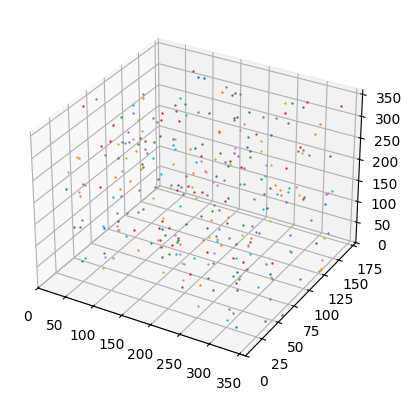

In [24]:
#grains=cmb.random(phi1=360,phi=90,phi2=360,ngrain=1000)
#grains=np.loadtxt('/Users/yj/repo/vpsc/vpsc-dev-fld/mat/bcc/gamma_fib_ngr00100_sigma015.cmb',skiprows=4)
#grains=np.loadtxt('/Users/youngung/repo/vpsc-fld-yld/examples/ex15_FLD/dat/B_ST_00100.cmb',skiprows=4)
grains=np.loadtxt('/Users/youngung/repo/evpsc/matData/vpscData/STS304/STS304_300.cmb',skiprows=4)



#grains=np.loadtxt('/Users/yj/repo/vpsc/vpsc-dev-fld/examples/ex15_FLD/dat/B_ST_02000.cmb',skiprows=4)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(grains)):
    ph1,ph,ph2=grains[i][:3]
    ax.scatter(ph1,ph,ph2,'.',s=0.5)

ax.set_xlim(0,360)
ax.set_ylim(0,180)
ax.set_zlim(0,360)

## Given the pole (hkl), find an equivalent set of poles with crystal symmetry is applied.

(24, 3, 3)


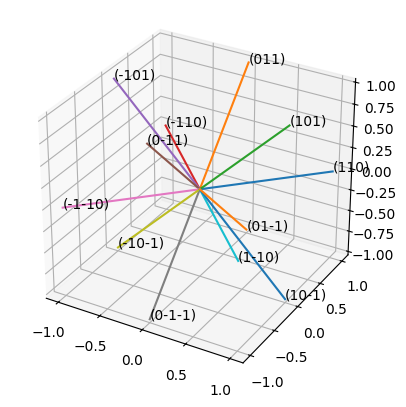

In [25]:
#upf.polefigure.cells(pole=[1,0,0],dm=7.5,dn=7.5,csym='cubic',poles_gr=grains)
from TX.sym import cv, cubic
vect=np.array([1,1,0]) ## hkl miller indices
#vect=vect/sqrt((vect**2).sum())
H=cubic()
print(H.shape)
vect_fam = np.zeros((len(H),3))
for i in range(len(H)):
    vect_fam[i,:] = np.dot(H[i],vect)

## sort only the unique vectors.
poles_ca = []
for i in range(len(H)):
    cH=vect_fam[i].copy()
    if upf.__isunique__(a=cH,b=poles_ca):
        poles_ca.append(cH)

#print len(H),'->',len(poles_ca)

#include inverse directions.
n=len(poles_ca)
for i in range(n):
    poles_ca.append(poles_ca[i]*(-1))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(poles_ca)):
    x,y,z=poles_ca[i][:]
    l, = ax.plot(xs=[0,x],ys=[0,y],zs=[0,z])
    ax.text(x,y,z,'(%i%i%i)'%(x,y,z))
    
ax.set_aspect('equal')

## Find poles of grains 

In [26]:
def projection(pole=None, agrain=None):
    """                                                                                                                                                                                    
    Projects a pole (vector) to projection plane.                                                                                                                                          
    (default is stereography projection)                                                                                                                                                   
                                                                                                                                                                                           
    pole = [1,1,1] or [1,1,0] something like this.                                                                                                                                         
                                                                                                                                                                                           
    The stereographic projection uses vectors pointing at                                                                                                                                  
    southern hemisphere.                                                                                                                                                                   
                                                                                                                                                                                           
    Arguments                                                                                                                                                                              
    ---------                                                                                                                                                                              
    pole = None                                                                                                                                                                            
    agrain = [ph1, phi, phi2, vf]                                                                                                                                                          
    """
    #normalization of the miller indices                                                                                                                                                   
    pole = pole / np.sqrt(pole[0]**2 + pole[1]**2 + pole[2]**2)
    a,b,c = pole[0:3]
    ###  mid-plane projection (z=0)                                                                                                                                                        
    if abs(c-1)<1e-8:
        # pole[0] = 0; pole[1]=0; pole[2] = 1                                                                                                                                              
        X=0; Y=0
    else:
        X = a/(c-1)

        Y = b/(c-1)
    return X,Y



In [ ]:
poles_sa =np.zeros((len(grains),len(poles_ca),3))
poles_wgt=np.zeros((len(grains),len(poles_ca)))

t0=time.time()
t_euler = 0.
for i in range(len(grains)):
    phi1,phi,phi2,wgt=grains[i]
    t_=time.time()
    amat = euler(phi1,phi,phi2,echo=False) ## ca<-sa
    t_=time.time()-t_
    t_euler=t_euler+t_
    for j in range(len(poles_ca)):
        p = poles_ca[j]
        p = p/(np.sqrt((p**2).sum()))
        poles_sa[i,j,:]=np.dot(amat.T,p)
        poles_wgt[i,j]=wgt

uet(time.time()-t0,head='time spent to get all poles')
uet(t_euler,head='Time spent in euler')

        
poles_sa = poles_sa.reshape((len(grains)*len(poles_ca),3))
poles_wgt = poles_wgt.reshape((len(grains)*len(poles_ca)))

fig=plt.figure()
#ax=fig.add_subplot(221)
ax=fig.add_subplot(111, projection='3d')

t=time.time()
t_proj = 0.
t_plot = 0.
for i in range(len(poles_sa)):
    t_=time.time()
    #X,Y = proj_cy.projection(poles_sa[i]) 
    X,Y = projection(poles_sa[i])#proj_f(poles_sa[i])
    t_ = time.time()-t_
    t_proj=t_proj + t_
    x,y,z=poles_sa[i]
    t_=time.time()
    ax.scatter(x,y,z,color='r',s=0.2)
    if (X**2+Y**2)<=1:
        ax.scatter(X,Y,0,s=0.10,color='k')
    t_ = time.time()-t_
    t_plot = t_plot + t_

print
uet(time.time()-t0,head='time spent to get all poles projected')
print
uet(t_proj,head='time spent for projection')
print
uet(t_plot,head='time spent for plotting')

ths=np.linspace(-np.pi,pi,360)
xs=np.cos(ths);ys=np.sin(ths)
plot(xs,ys,'-',color='k',lw=0.5)

ax.set_xlim(-1.1,1.1); ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
## poles_sa and xy

time spent for plotting:           5 [sec]s]     5 [sec]

## Pole figures in Cartesian coordinate

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)

for i in range(len(poles_sa)):
    #X,Y = upf.projection(pole=poles_sa[i])
    #X,Y = proj_f(poles_sa[i])
    X,Y=projection(poles_sa[i])
    if (X**2+Y**2)<=1:
        ax.plot(X,Y,'k.')
        
xs=np.array([1.,0,0.])
xs_=np.array([-1.,0,0.])
ys=np.array([0,1.,0])
ys_=np.array([0,-1.,0])
zs=np.array([0,0,-1.])

X,Y=projection(xs)
ax.plot(X,Y,'ro')
ax.text(X,Y,'+x')
X,Y=projection(xs_)
ax.plot(X,Y,'rx')
ax.text(X,Y,'-x')
X,Y=projection(ys)
ax.plot(X,Y,'bo')
ax.text(X,Y,'y')
X,Y=projection(ys_)
ax.plot(X,Y,'bx')
ax.text(X,Y,'-y')
# X,Y=proj_f(zs)
# print 'zs,X,Y',zs,X,Y
# ax.plot(X,Y,'yo')
    
ths=np.linspace(-np.pi,pi,360)
xs=np.cos(ths);ys=np.sin(ths)
plot(xs,ys,'-',color='k',lw=0.5)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
ax.set_axis_off()

In [ ]:
fig=plt.figure()
ax = plt.subplot(111, projection='polar')

R=[]; T=[]
for i in range(len(poles_sa)):
    X,Y = upf.projection(pole=poles_sa[i])
    #X,Y = proj_f(poles_sa[i])
    if (X**2+Y**2)<=1 or True:
        r, theta = upf.cart2polar(X,Y)
        R.append(r); T.append(theta)
        plot(theta,r,'k.')
        ax.grid(False)

#r,t = np.meshgrid(R, T)

#w = griddata(R,T,poles_wgt, r, t,interp=u'linear')
#ax.contourf(t, r, w)
ax.set_rmax(1,)

## Mapped to Cartesian coordinate of ($\phi$,$\theta$)
- phi ($\phi$): tilting  (distance from the pole)
- theta ($\theta)$: rotation


In [ ]:
fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)

dx=90.;dy=45.; tiny=1e-9
#dx=15;dy=15; tiny=1e-9
x=np.arange(-180.,180.+tiny,dx)
y=np.arange(0.,180.+tiny,dy)

## boundary of a polar pole:
ax1.plot([-180,-180,180,180,-180],[0,90,90,0,0],'--',color='gray',label='pole boundary')
nx, ny = int(360./dx), int(180./dy)
f=np.zeros((nx,ny))
#print('f.shape:',f.shape)

x_node = np.arange(-180.,180.+tiny,dx)
y_node = np.arange(0.,90.+tiny,dy)
nx_node=len(x_node)
ny_node=len(y_node)
nodes=np.zeros((nx_node,ny_node))
#print('nodes.shape:', nodes.shape)

X, Y = meshgrid(x, y)
for i in range(len(x)):
    for j in range(len(y)):
        if i+j==0:
            lab1='node[i,j]'; lab2='f[i,j]'
        else:
            lab1=None; lab2=None
        ax1.plot(x[i],y[j],'r+',ms=2,label=lab1)
        ax1.plot(x[i]+dx/2.,y[j]+dy/2.,'o',
                 mfc='b',mec='None',
                 alpha=1.0,ms=4,label=lab2)

print('ylim:', y[-1])
phs,ths,wgts=[],[],[]
for i in range(len(poles_sa)):
    X,Y = upf.projection(pole=poles_sa[i])
    theta,phi = upf.cart2sph(poles_sa[i])
    x_,y_=theta*180/np.pi,phi*180/np.pi
    ax1.plot(x_,y_,'m.',ms=6,alpha=0.2)

    if  X**2+Y**2>=1. or True:
        #ax.plot(X,Y,'k.')
        wgts.append(poles_wgt[i]) ## weights
        phs.append(phi)
        ths.append(theta)        

        ## Determine ix and iy to be assigned
        ix = int((x_+180)/dx-1e-9)
        iy = int( y_/dy-1e-9)
        f[ix,iy]=f[ix,iy]+poles_wgt[i]

for i in range(nx):
    for j in range(ny):
        ax1.text(x[i]+dx/2.,y[j]+dy/2.,'%3.2f'%f[i,j])
## assign to f.

fsum=f[:,:int(ny/2)].flatten().sum()

## Normalization
#inorm=False
inorm=True
if inorm:
    print('nx,ny:', nx,ny)
    z=np.zeros((ny+1))
    dz = (pi)/float(ny)
    for i in range(ny+1):
        z[i]=dz*i
    dx_=2.*pi/nx
    for ix in range(nx):
        for iy in range(ny):
            fnorm = (np.cos(z[iy])-np.cos(z[iy+1]))*dx_ / (2.*np.pi)
            f[ix,iy]=f[ix,iy]/fnorm/fsum
##


## Extention of f_bounds
f_bounds=np.zeros((nx+2,ny+2))
f_bounds[1:-1,1:-1]=f[:,:]
f_bounds[-1,1:-1]=f[0,:]
f_bounds[0,1:-1]=f[-1,:]
f_bounds[1:-1,0]=f[:,-1]
f_bounds[0,0]=f_bounds[0,-2]
f_bounds[-1,0]=f_bounds[-1,-2]
f_bounds[:,-1]=f_bounds[:,1]

for i in range(nx+2):
    for j in range(ny+2):
        ax1.plot(dx*(i-1)+dx/2.-180.,dy*(j-1)+dy/2.,'g+')
        if f_bounds[i,j]!=0:
            ax1.text(dx*(i-1)-180+dx/4.,dy*(j-1)+dy/4.,'%3.2f'%f_bounds[i,j],color='green')

## Average by neighbours
for i in range(len(nodes)):
    for j in range(len(nodes[i])):
        nodes[i][j] = (f_bounds[i][j]+f_bounds[i+1][j]+f_bounds[i][j+1]+f_bounds[i+1][j+1])/4.
        ax1.text(x[i],y[j],'%.4f'%nodes[i][j])

## Deco
dw=dx*0.8
ax1.set_xlim(-180-dw,180.+dw)
ax1.set_xticks(np.arange(-180,180.001,90)); ax1.set_yticks(np.arange(0,180.001,30))
ax1.set_ylim(0-dw,180+dw)
ax1.set_xlabel(r'$\theta$'); ax1.set_ylabel(r'$\phi$')
ax1.legend(bbox_to_anchor=(1.5,1))
# print f

In [ ]:
#dx=90.;dy=45.; tiny=1e-9
dx=15;dy=15; tiny=1e-9
x=np.arange(-180.,180.+tiny,dx)
y=np.arange(0.,180.+tiny,dy)

## boundary of a polar pole:
nx, ny = int(360./dx), int(180./dy)
f=np.zeros((nx,ny))
#print('f.shape:',f.shape)

x_node = np.arange(-180.,180.+tiny,dx)
y_node = np.arange(0.,90.+tiny,dy)
nx_node=len(x_node)
ny_node=len(y_node)
nodes=np.zeros((nx_node,ny_node))
#print('nodes.shape:', nodes.shape)

X, Y = meshgrid(x, y)
for i in range(len(x)):
    for j in range(len(y)):
        if i+j==0:
            lab1='node[i,j]'; lab2='f[i,j]'
        else:
            lab1=None; lab2=None

#print('ylim:', y[-1])
phs,ths,wgts=[],[],[]
for i in range(len(poles_sa)):
    X,Y = upf.projection(pole=poles_sa[i])
    theta,phi = upf.cart2sph(poles_sa[i])
    x_,y_=theta*180/np.pi,phi*180/np.pi
    if  X**2+Y**2>=1. or True:
        #ax.plot(X,Y,'k.')
        wgts.append(poles_wgt[i]) ## weights
        phs.append(phi)
        ths.append(theta)        

        ## Determine ix and iy to be assigned
        ix = int((x_+180)/dx-1e-9)
        iy = int( y_/dy-1e-9)
        f[ix,iy]=f[ix,iy]+poles_wgt[i]

## assign to f.

fsum=f[:,:int(ny/2)].flatten().sum()

## Normalization
#inorm=False
inorm=True
if inorm:
    #print('nx,ny:', nx,ny)
    z=np.zeros((ny+1))
    dz = (pi)/float(ny)
    for i in range(ny+1):
        z[i]=dz*i
    dx_=2.*pi/nx
    for ix in range(nx):
        for iy in range(ny):
            fnorm = (np.cos(z[iy])-np.cos(z[iy+1]))*dx_ / (2.*np.pi)
            f[ix,iy]=f[ix,iy]/fnorm/fsum
##


## Extention of f_bounds
f_bounds=np.zeros((nx+2,ny+2))
f_bounds[1:-1,1:-1]=f[:,:]
f_bounds[-1,1:-1]=f[0,:]
f_bounds[0,1:-1]=f[-1,:]
f_bounds[1:-1,0]=f[:,-1]
f_bounds[0,0]=f_bounds[0,-2]
f_bounds[-1,0]=f_bounds[-1,-2]
f_bounds[:,-1]=f_bounds[:,1]

## Average by neighbours
for i in range(len(nodes)):
    for j in range(len(nodes[i])):
        nodes[i][j] = (f_bounds[i][j]+f_bounds[i+1][j]+f_bounds[i][j+1]+f_bounds[i+1][j+1])/4.

## Deco
dw=dx*0.8

## Contour in Cartesian coordinate of ($\phi$,$\theta$)

In [ ]:
fig=plt.figure(figsize=(12,4))
ax1=fig.add_subplot(131);
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)

XN,YN=meshgrid(x_node,y_node)

#print nodes.shape
cnt=ax1.contourf(XN,YN,nodes.T)
#colorbar()

new=nodes.copy()
n = 1
for i in range(n):
    new[:,i]=new[:,i].sum()/len(new[:,i])
cnt=ax2.contour(XN,YN,new.T)
cnt=ax3.contourf(XN,YN,new.T,cmap='gray_r')
#ax2.imshow(new.T,interpolation='cubic')
#colorbar()

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
ax.contourf(XN*np.pi/180.+np.pi/2.,YN*np.pi/180.,new.T)

## Example (AZ31 alloy texture)

In [ ]:
from TX import upf, cmb
import time
#reload(upf)

from MP.lib import whichcomp

#filename='/Users/youngung/repo/vpsc-fld-yld/examples/ex15_FLD/magnesium/az31/LS_AZ31_1.3mm.tex'
filename='/Users/youngung/repo/evpsc/matData/vpscData/Mg_AZ31B/AZ31B_6000_new.cmb'

#if whichcomp.clues()=='Darwin': ## My MBA Darwin
#    filename='/Users/yj/repo/vpsc/vpsc-dev-fld/examples/ex15_FLD/magnesium/az31/LS_AZ31_1.3mm.tex'
#elif whichcomp.clues()=='Linux': ## My CTCMS Linux
#    filename='/users/ynj/repo/vpsc-fld/examples/ex15_FLD/magnesium/ze10/LS_ZE10_1.3mm.tex'

mypf=upf.polefigure(filename=filename,
    #grains=grs_iso,
    csym='hexag',cdim=[1,1,1.624],cang=[90,90,120])

t0=time.time()
mypf.pf_new(poles=[[0,0,0,2],[1,0,-1,1],[1,0,-1,0]],
            n_rim=1,#lev_opt=0,#lev_norm_log=True,
            nlev=7,cmap='jet',dth=9,dph=9.,mn=1,ismooth=3)
print('pf_new time:', time.time()-t0)

gcf().savefig('Mg_texture.pdf',bbox_inches='tight')
gcf().savefig('Mg_texture.png',bbox_inches='tight',transparent=True)